# What is done?
### 1. Train baseline LightGBM model on 30 min forecasting

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import lightgbm as lgb
#import shap
import pickle

#shap.initjs()

from utils import *

In [6]:
# load data
data = pd.read_parquet('./data/ds_1min_30min_v1.parquet')
data = data.sort_values(by=['DATE']).reset_index(drop=True)
print('Shape: ', data.shape)
data.head(3)

Shape:  (4706, 206)


,DATE,T1,T2,T3,T4,MODE,T1_M30,T2_M30,T3_M30,T4_M30,...,MODE_M10,MODE_M9,MODE_M8,MODE_M7,MODE_M6,MODE_M5,MODE_M4,MODE_M3,MODE_M2,MODE_M1
0,2018-12-16 06:30:02,-7.5,28.3,28.6,26.9,0,-6.7,30.4,32.2,29.8,...,0,0,0,0,0,0,0,0,0,0
1,2018-12-16 06:31:02,-7.4,28.2,28.5,26.7,0,-6.8,30.4,32.2,29.8,...,0,0,0,0,0,0,0,0,0,0
2,2018-12-16 06:32:02,-7.5,28.0,28.3,26.5,0,-7.0,30.4,32.3,29.8,...,0,0,0,0,0,0,0,0,0,0


In [7]:
assert data['DATE'].unique().shape[0] == data.shape[0]

In [8]:
val_size = 150
test_size = 30

data_trainval = data.iloc[:-test_size].copy()

data_train = data.iloc[:-(val_size + test_size)].copy()
data_val = data.iloc[-(val_size + test_size): -test_size].copy()
data_test = data.iloc[-test_size:].copy()

del data

In [9]:
features = [s for s in data_train.columns if s not in ['T1', 'T2', 'T3', 'T4', 'MODE', 'DATE']]
target_label = ['T4']

In [10]:
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [11]:
dts = lgb.Dataset(data_train[features], label=data_train[target_label])
dts = dts.construct()
dtsv = dts.create_valid(data_val[features], label=data_val[target_label])

In [13]:
params = {
    'application': 'regression_l2',
    'learning_rate': 0.005,
    #'reg_alpha': 1e-1,
    # 'min_data_in_leaf': 100,
    'num_leaves': 63,
    'metric': 'l2'
}

In [14]:
bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'],
                num_boost_round = 10000, early_stopping_rounds = 10)

[1]	Validation's l2: 9.42109
Training until validation scores don't improve for 10 rounds.
[2]	Validation's l2: 9.33587
[3]	Validation's l2: 9.25151
[4]	Validation's l2: 9.16801
[5]	Validation's l2: 9.08368
[6]	Validation's l2: 8.98672
[7]	Validation's l2: 8.88964
[8]	Validation's l2: 8.80959
[9]	Validation's l2: 8.72863
[10]	Validation's l2: 8.64963
[11]	Validation's l2: 8.57097
[12]	Validation's l2: 8.49358
[13]	Validation's l2: 8.42593
[14]	Validation's l2: 8.36034
[15]	Validation's l2: 8.28386
[16]	Validation's l2: 8.19887
[17]	Validation's l2: 8.12089
[18]	Validation's l2: 8.03767
[19]	Validation's l2: 7.96214
[20]	Validation's l2: 7.88066
[21]	Validation's l2: 7.80943
[22]	Validation's l2: 7.7368
[23]	Validation's l2: 7.66723
[24]	Validation's l2: 7.59681
[25]	Validation's l2: 7.5284
[26]	Validation's l2: 7.45179
[27]	Validation's l2: 7.38208
[28]	Validation's l2: 7.31705
[29]	Validation's l2: 7.2511
[30]	Validation's l2: 7.18497
[31]	Validation's l2: 7.12065
[32]	Validation's l2

[267]	Validation's l2: 1.46701
[268]	Validation's l2: 1.45895
[269]	Validation's l2: 1.45206
[270]	Validation's l2: 1.44348
[271]	Validation's l2: 1.43604
[272]	Validation's l2: 1.42916
[273]	Validation's l2: 1.42067
[274]	Validation's l2: 1.41494
[275]	Validation's l2: 1.40676
[276]	Validation's l2: 1.39847
[277]	Validation's l2: 1.39185
[278]	Validation's l2: 1.38522
[279]	Validation's l2: 1.37731
[280]	Validation's l2: 1.37087
[281]	Validation's l2: 1.36443
[282]	Validation's l2: 1.35816
[283]	Validation's l2: 1.35047
[284]	Validation's l2: 1.34558
[285]	Validation's l2: 1.33954
[286]	Validation's l2: 1.33486
[287]	Validation's l2: 1.32741
[288]	Validation's l2: 1.32232
[289]	Validation's l2: 1.31846
[290]	Validation's l2: 1.31261
[291]	Validation's l2: 1.30684
[292]	Validation's l2: 1.30202
[293]	Validation's l2: 1.29624
[294]	Validation's l2: 1.29059
[295]	Validation's l2: 1.2884
[296]	Validation's l2: 1.28422
[297]	Validation's l2: 1.28117
[298]	Validation's l2: 1.27615
[299]	Val

[527]	Validation's l2: 0.831714
[528]	Validation's l2: 0.830536
[529]	Validation's l2: 0.829888
[530]	Validation's l2: 0.829375
[531]	Validation's l2: 0.828691
[532]	Validation's l2: 0.827013
[533]	Validation's l2: 0.826143
[534]	Validation's l2: 0.825423
[535]	Validation's l2: 0.823813
[536]	Validation's l2: 0.82294
[537]	Validation's l2: 0.821815
[538]	Validation's l2: 0.820536
[539]	Validation's l2: 0.819272
[540]	Validation's l2: 0.81869
[541]	Validation's l2: 0.817591
[542]	Validation's l2: 0.817081
[543]	Validation's l2: 0.816214
[544]	Validation's l2: 0.816232
[545]	Validation's l2: 0.815163
[546]	Validation's l2: 0.81443
[547]	Validation's l2: 0.813495
[548]	Validation's l2: 0.812314
[549]	Validation's l2: 0.811271
[550]	Validation's l2: 0.81044
[551]	Validation's l2: 0.809602
[552]	Validation's l2: 0.808853
[553]	Validation's l2: 0.808765
[554]	Validation's l2: 0.808383
[555]	Validation's l2: 0.807689
[556]	Validation's l2: 0.807059
[557]	Validation's l2: 0.806424
[558]	Valida

In [15]:
save(bst, './saved_models/30min/lgbm_30min_v1.pkl')

In [16]:
y_test = bst.predict(data_test[features])
y_val = bst.predict(data_val[features])
y_train = bst.predict(data_train[features])

In [17]:
#print('CV score: %.3f' % grid_lgb.best_score_)
print('MAE on train: %.3f' % mean_absolute_error(data_train[target_label].values, y_train))
print('MAE on val: %.3f' % mean_absolute_error(data_val[target_label].values, y_val))
print('MAE on test: %.3f' % mean_absolute_error(data_test[target_label].values, y_test))
print()
print('RMSE on train: %.2f' % np.sqrt(mean_squared_error(data_train[target_label].values, y_train)))
print('RMSE on val: %.2f' % np.sqrt(mean_squared_error(data_val[target_label].values, y_val)))
print('RMSE on test: %.2f' % np.sqrt(mean_squared_error(data_test[target_label].values, y_test)))

MAE on train: 0.299
MAE on val: 0.711
MAE on test: 1.575

RMSE on train: 0.55
RMSE on val: 0.89
RMSE on test: 1.78


In [18]:
bst.best_iteration

599

In [19]:
dts = lgb.Dataset(data_trainval[features], label=data_trainval[target_label])
dts = dts.construct()
dtst = dts.create_valid(data_test[features], label=data_test[target_label])

In [20]:
bst = lgb.train(params, dts, valid_sets = [dtst], valid_names = ['Test'],
                num_boost_round=bst.best_iteration)

[1]	Test's l2: 4.90639
[2]	Test's l2: 4.88608
[3]	Test's l2: 4.8662
[4]	Test's l2: 4.84641
[5]	Test's l2: 4.82613
[6]	Test's l2: 4.81622
[7]	Test's l2: 4.79669
[8]	Test's l2: 4.78667
[9]	Test's l2: 4.76757
[10]	Test's l2: 4.7579
[11]	Test's l2: 4.74433
[12]	Test's l2: 4.73061
[13]	Test's l2: 4.71756
[14]	Test's l2: 4.70348
[15]	Test's l2: 4.69121
[16]	Test's l2: 4.67817
[17]	Test's l2: 4.6654
[18]	Test's l2: 4.65728
[19]	Test's l2: 4.64026
[20]	Test's l2: 4.63085
[21]	Test's l2: 4.62169
[22]	Test's l2: 4.60442
[23]	Test's l2: 4.59497
[24]	Test's l2: 4.58624
[25]	Test's l2: 4.5804
[26]	Test's l2: 4.56796
[27]	Test's l2: 4.55767
[28]	Test's l2: 4.54144
[29]	Test's l2: 4.5293
[30]	Test's l2: 4.52199
[31]	Test's l2: 4.51263
[32]	Test's l2: 4.49343
[33]	Test's l2: 4.48222
[34]	Test's l2: 4.4658
[35]	Test's l2: 4.44752
[36]	Test's l2: 4.43474
[37]	Test's l2: 4.4192
[38]	Test's l2: 4.40972
[39]	Test's l2: 4.3903
[40]	Test's l2: 4.35916
[41]	Test's l2: 4.35
[42]	Test's l2: 4.31868
[43]	Test's 

[334]	Test's l2: 2.83774
[335]	Test's l2: 2.83157
[336]	Test's l2: 2.8314
[337]	Test's l2: 2.83931
[338]	Test's l2: 2.83545
[339]	Test's l2: 2.83162
[340]	Test's l2: 2.82868
[341]	Test's l2: 2.82449
[342]	Test's l2: 2.82229
[343]	Test's l2: 2.81659
[344]	Test's l2: 2.81503
[345]	Test's l2: 2.81301
[346]	Test's l2: 2.80931
[347]	Test's l2: 2.80725
[348]	Test's l2: 2.81431
[349]	Test's l2: 2.81593
[350]	Test's l2: 2.81616
[351]	Test's l2: 2.81291
[352]	Test's l2: 2.80729
[353]	Test's l2: 2.80171
[354]	Test's l2: 2.79808
[355]	Test's l2: 2.79049
[356]	Test's l2: 2.78724
[357]	Test's l2: 2.78688
[358]	Test's l2: 2.78334
[359]	Test's l2: 2.78298
[360]	Test's l2: 2.78428
[361]	Test's l2: 2.77913
[362]	Test's l2: 2.77936
[363]	Test's l2: 2.77517
[364]	Test's l2: 2.77646
[365]	Test's l2: 2.77726
[366]	Test's l2: 2.77655
[367]	Test's l2: 2.77735
[368]	Test's l2: 2.77828
[369]	Test's l2: 2.77464
[370]	Test's l2: 2.77729
[371]	Test's l2: 2.77697
[372]	Test's l2: 2.77931
[373]	Test's l2: 2.77921
[

In [21]:
y_trainval = bst.predict(data_trainval[features].values)
y_test = bst.predict(data_test[features].values)

In [22]:
#print('CV score: %.3f' % grid_lgb.best_score_)
print('MAE on trainval: %.3f' % mean_absolute_error(data_train[target_label].values, y_train))
print('MAE on test: %.3f' % mean_absolute_error(data_test[target_label].values, y_test))
print()
print('RMSE on trainval: %.2f' % np.sqrt(mean_squared_error(data_train[target_label].values, y_train)))
print('RMSE on test: %.2f' % np.sqrt(mean_squared_error(data_test[target_label].values, y_test)))

MAE on trainval: 0.299
MAE on test: 1.373

RMSE on trainval: 0.55
RMSE on test: 1.60


In [23]:
sc = bst.feature_importance(importance_type = 'gain')
score = pd.DataFrame(100 * sc / np.sum(sc),
                     index = bst.feature_name(), columns = ['Score'])

In [24]:
score = score.sort_values('Score', ascending=False)

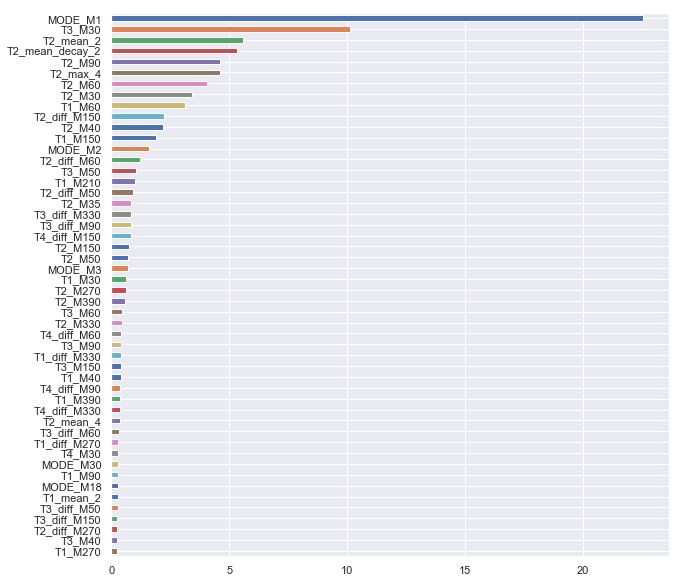

In [25]:
score.head(50).Score.plot.barh(grid=True, figsize=(10,10)).invert_yaxis()

In [31]:
res = data_test[['DATE', 'T4']].copy()

In [32]:
res['PRED'] = y_test

In [43]:
def plot_pred(results):
    plt.figure(figsize=(18,10))
    plt.title('Timeseries plot')
    plt.plot(results['DATE'], results['T4'], c='green', ls='-', lw=1, label='$T_4$')
    plt.plot(results['DATE'], results['PRED'], 'r-.', lw=1, label='$\hat{T_4}$ pred')
    plt.xlabel('Datetime')
    plt.ylim((0, 30))
    plt.legend(loc='best')
    plt.show()

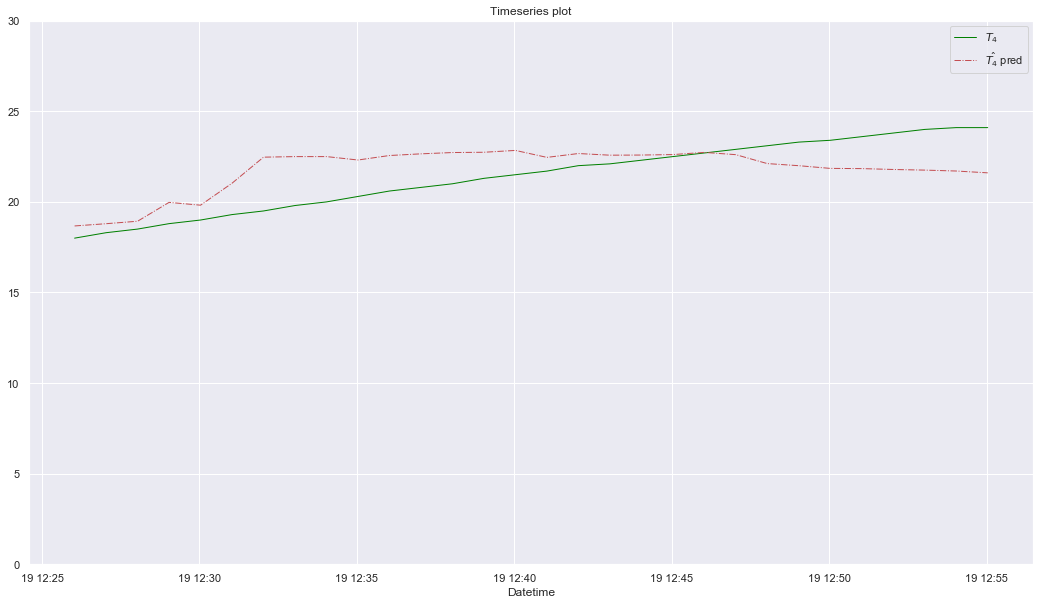

In [44]:
plot_pred(res)